In [ ]:
import pandas as pd
import pickle
import numpy as np
from yaml import safe_load
import os
from tqdm import tqdm
import warnings
%pip install xgboost
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [ ]:
filenames = []
for file in os.listdir('data'):
    if file.endswith('.yaml'):
        filenames.append(os.path.join('data',file))

In [ ]:
final_df = pd.DataFrame()
counter = 1
for file in tqdm(filenames):
    with open(file, 'r') as f:
        df = pd.json_normalize(safe_load(f))
        df['match_id'] = counter
        final_df = pd.concat([final_df,df])
        counter+=1
        
final_df

In [ ]:
backup = final_df.copy()

In [ ]:
final_df.drop(columns=[
    'meta.data_version',
    'meta.created',
    'meta.revision',
    'info.outcome.bowl_out',
    'info.bowl_out',
    'info.supersubs.South Africa',
    'info.supersubs.New Zealand',
    'info.outcome.eliminator',
    'info.outcome.result',
    'info.outcome.method',
    'info.neutral_venue',
    'info.match_type_number',
    'info.outcome.by.runs',
    'info.outcome.by.wickets'
],inplace=True)

In [ ]:
final_df['info.gender'].value_counts()

In [ ]:
final_df = final_df[final_df['info.gender'] == 'male']
final_df.drop(columns=['info.gender'],inplace=True)
final_df

In [ ]:
final_df['info.match_type'].value_counts()

In [ ]:
final_df['info.overs'].value_counts()

In [ ]:
final_df = final_df[final_df['info.overs'] == 20]
final_df.drop(columns=['info.overs','info.match_type'],inplace=True)
final_df

In [ ]:
import pickle
pickle.dump(final_df,open('dataset_level1.pkl','wb'))

In [ ]:
matches = pickle.load(open('dataset_level1.pkl','rb'))

In [ ]:
#matches = pickle.load(open('dataset_level1.pkl','rb'))
matches.iloc[0]['innings'][0]['1st innings']['deliveries']

In [ ]:
count = 1
delivery_df = pd.DataFrame()
for index, row in matches.iterrows():
    if count in [75,108,150,180,268,360,443,458,584,748,982,1052,1111,1226,1345]:
        count+=1
        continue
    count+=1
    ball_of_match = []
    batsman = []
    bowler = []
    runs = []
    player_of_dismissed = []
    teams = []
    batting_team = []
    match_id = []
    city = []
    venue = []
    for ball in row['innings'][0]['1st innings']['deliveries']:
        for key in ball.keys():
            match_id.append(count)
            batting_team.append(row['innings'][0]['1st innings']['team'])
            teams.append(row['info.teams'])
            ball_of_match.append(key)
            batsman.append(ball[key]['batsman'])
            bowler.append(ball[key]['bowler'])
            runs.append(ball[key]['runs']['total'])
            city.append(row['info.city'])
            venue.append(row['info.venue'])
            try:
                player_of_dismissed.append(ball[key]['wicket']['player_out'])
            except:
                player_of_dismissed.append('0')
    loop_df = pd.DataFrame({
            'match_id':match_id,
            'teams':teams,
            'batting_team':batting_team,
            'ball':ball_of_match,
            'batsman':batsman,
            'bowler':bowler,
            'runs':runs,
            'player_dismissed':player_of_dismissed,
            'city':city,
            'venue':venue
        })
    delivery_df = pd.concat([delivery_df,loop_df])

In [ ]:
def bowl(row):
    for team in row['teams']:
        if team != row['batting_team']:
            return team

In [ ]:
delivery_df['bowling_team'] = delivery_df.apply(bowl,axis=1)

In [ ]:
delivery_df.drop(columns=['teams'],inplace=True)

In [ ]:
delivery_df['batting_team'].unique()

In [ ]:
teams = [
    'Australia',
    'India',
    'Bangladesh',
    'New Zealand',
    'South Africa',
    'England',
    'West Indies',
    'Afghanistan',
    'Pakistan',
    'Sri Lanka'    
]

In [ ]:
delivery_df = delivery_df[delivery_df['batting_team'].isin(teams)]
delivery_df = delivery_df[delivery_df['bowling_team'].isin(teams)]

In [ ]:
output = delivery_df[['match_id','batting_team','bowling_team','ball','runs','player_dismissed','city','venue']]

In [ ]:
pickle.dump(output,open('dataset_level2.pkl','wb'))

In [2]:
df = pickle.load(open('dataset_level2.pkl','rb'))

In [3]:
df

# batting_team
# bowling team
# city
# current score
# ball left
# wickets left
# current rr
# last five

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,venue
0,2,Australia,Sri Lanka,0.1,0,0,NaN,Melbourne Cricket Ground
1,2,Australia,Sri Lanka,0.2,0,0,NaN,Melbourne Cricket Ground
2,2,Australia,Sri Lanka,0.3,1,0,NaN,Melbourne Cricket Ground
3,2,Australia,Sri Lanka,0.4,2,0,NaN,Melbourne Cricket Ground
4,2,Australia,Sri Lanka,0.5,0,0,NaN,Melbourne Cricket Ground
...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,Colombo,R Premadasa Stadium
122,964,Sri Lanka,Australia,19.4,0,0,Colombo,R Premadasa Stadium
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,Colombo,R Premadasa Stadium
124,964,Sri Lanka,Australia,19.6,2,0,Colombo,R Premadasa Stadium


In [4]:
df.isnull().sum()

match_id               0
batting_team           0
bowling_team           0
ball                   0
runs                   0
player_dismissed       0
city                8548
venue                  0
dtype: int64

In [5]:
df.drop(columns=['city'],inplace=True)

In [6]:
df.head(200)

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground
...,...,...,...,...,...,...,...
70,3,Australia,Sri Lanka,11.3,0,0,"Simonds Stadium, South Geelong"
71,3,Australia,Sri Lanka,11.4,1,0,"Simonds Stadium, South Geelong"
72,3,Australia,Sri Lanka,11.5,0,0,"Simonds Stadium, South Geelong"
73,3,Australia,Sri Lanka,11.6,1,0,"Simonds Stadium, South Geelong"


In [7]:
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground
...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,R Premadasa Stadium
122,964,Sri Lanka,Australia,19.4,0,0,R Premadasa Stadium
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,R Premadasa Stadium
124,964,Sri Lanka,Australia,19.6,2,0,R Premadasa Stadium


In [8]:
df['current_score'] = df.groupby('match_id')['runs'].cumsum()

In [9]:
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3
...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,R Premadasa Stadium,125
122,964,Sri Lanka,Australia,19.4,0,0,R Premadasa Stadium,125
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,R Premadasa Stadium,125
124,964,Sri Lanka,Australia,19.6,2,0,R Premadasa Stadium,127


In [9]:
df['over'] = df['ball'].apply(lambda x:str(x).split(".")[0])
df['ball_no'] = df['ball'].apply(lambda x:str(x).split(".")[1])
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score,over,ball_no
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0,0,1
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0,0,2
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1,0,3
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3,0,4
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3,0,5
...,...,...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,R Premadasa Stadium,125,19,3
122,964,Sri Lanka,Australia,19.4,0,0,R Premadasa Stadium,125,19,4
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,R Premadasa Stadium,125,19,5
124,964,Sri Lanka,Australia,19.6,2,0,R Premadasa Stadium,127,19,6


In [10]:
df['balls_bowled'] = (df['over'].astype('int')*6) + df['ball_no'].astype('int')
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score,over,ball_no,balls_bowled
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0,0,1,1
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0,0,2,2
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1,0,3,3
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3,0,4,4
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,R Premadasa Stadium,125,19,3,117
122,964,Sri Lanka,Australia,19.4,0,0,R Premadasa Stadium,125,19,4,118
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,R Premadasa Stadium,125,19,5,119
124,964,Sri Lanka,Australia,19.6,2,0,R Premadasa Stadium,127,19,6,120


In [11]:
df['balls_left'] = 120 - df['balls_bowled']
df['balls_left'] = df['balls_left'].apply(lambda x:0 if x<0 else x)
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score,over,ball_no,balls_bowled,balls_left
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0,0,1,1,119
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0,0,2,2,118
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1,0,3,3,117
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3,0,4,4,116
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3,0,5,5,115
...,...,...,...,...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,0,R Premadasa Stadium,125,19,3,117,3
122,964,Sri Lanka,Australia,19.4,0,0,R Premadasa Stadium,125,19,4,118,2
123,964,Sri Lanka,Australia,19.5,0,DM de Silva,R Premadasa Stadium,125,19,5,119,1
124,964,Sri Lanka,Australia,19.6,2,0,R Premadasa Stadium,127,19,6,120,0


In [12]:
df['player_dismissed'] = df['player_dismissed'].apply(lambda x:0 if x=='0' else 1)
df['player_dismissed'] = df['player_dismissed'].astype('int')
df['player_dismissed'] = df.groupby('match_id')['player_dismissed'].cumsum()
df['wickets_left'] = 10 - df['player_dismissed']

In [13]:
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score,over,ball_no,balls_bowled,balls_left,wickets_left
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0,0,1,1,119,10
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0,0,2,2,118,10
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1,0,3,3,117,10
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3,0,4,4,116,10
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3,0,5,5,115,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,8,R Premadasa Stadium,125,19,3,117,3,2
122,964,Sri Lanka,Australia,19.4,0,8,R Premadasa Stadium,125,19,4,118,2,2
123,964,Sri Lanka,Australia,19.5,0,9,R Premadasa Stadium,125,19,5,119,1,1
124,964,Sri Lanka,Australia,19.6,2,9,R Premadasa Stadium,127,19,6,120,0,1


In [14]:
df['crr'] = (df['current_score']*6)/df['balls_bowled']

In [15]:
df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,venue,current_score,over,ball_no,balls_bowled,balls_left,wickets_left,crr
0,2,Australia,Sri Lanka,0.1,0,0,Melbourne Cricket Ground,0,0,1,1,119,10,0.000000
1,2,Australia,Sri Lanka,0.2,0,0,Melbourne Cricket Ground,0,0,2,2,118,10,0.000000
2,2,Australia,Sri Lanka,0.3,1,0,Melbourne Cricket Ground,1,0,3,3,117,10,2.000000
3,2,Australia,Sri Lanka,0.4,2,0,Melbourne Cricket Ground,3,0,4,4,116,10,4.500000
4,2,Australia,Sri Lanka,0.5,0,0,Melbourne Cricket Ground,3,0,5,5,115,10,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,964,Sri Lanka,Australia,19.3,1,8,R Premadasa Stadium,125,19,3,117,3,2,6.410256
122,964,Sri Lanka,Australia,19.4,0,8,R Premadasa Stadium,125,19,4,118,2,2,6.355932
123,964,Sri Lanka,Australia,19.5,0,9,R Premadasa Stadium,125,19,5,119,1,1,6.302521
124,964,Sri Lanka,Australia,19.6,2,9,R Premadasa Stadium,127,19,6,120,0,1,6.350000


In [16]:
groups = df.groupby('match_id')

match_ids = df['match_id'].unique()
last_five = []
for id in match_ids:
    last_five.extend(groups.get_group(id).rolling(window=30)['runs'].sum().values.tolist())

In [17]:
df['last_five'] = last_five

In [18]:
df[['batting_team','bowling_team','venue','current_score','balls_left','wickets_left','crr','last_five']]

,batting_team,bowling_team,venue,current_score,balls_left,wickets_left,crr,last_five
0,Australia,Sri Lanka,Melbourne Cricket Ground,0,119,10,0.000000,NaN
1,Australia,Sri Lanka,Melbourne Cricket Ground,0,118,10,0.000000,NaN
2,Australia,Sri Lanka,Melbourne Cricket Ground,1,117,10,2.000000,NaN
3,Australia,Sri Lanka,Melbourne Cricket Ground,3,116,10,4.500000,NaN
4,Australia,Sri Lanka,Melbourne Cricket Ground,3,115,10,3.600000,NaN
...,...,...,...,...,...,...,...,...
121,Sri Lanka,Australia,R Premadasa Stadium,125,3,2,6.410256,32.0
122,Sri Lanka,Australia,R Premadasa Stadium,125,2,2,6.355932,32.0
123,Sri Lanka,Australia,R Premadasa Stadium,125,1,1,6.302521,32.0
124,Sri Lanka,Australia,R Premadasa Stadium,127,0,1,6.350000,33.0


In [19]:
final_df = df.groupby('match_id').sum()['runs'].reset_index().merge(df,on='match_id')

In [20]:
final_df=final_df[['batting_team','bowling_team','venue','current_score','balls_left','wickets_left','crr','last_five','runs_x']]

In [21]:
final_df.dropna(inplace=True)

In [22]:
final_df.isnull().sum()

batting_team     0
bowling_team     0
venue            0
current_score    0
balls_left       0
wickets_left     0
crr              0
last_five        0
runs_x           0
dtype: int64

In [23]:
final_df = final_df.sample(final_df.shape[0])

In [24]:
final_df

,batting_team,bowling_team,venue,current_score,balls_left,wickets_left,crr,last_five,runs_x
42653,West Indies,Sri Lanka,Pallekele International Cricket Stadium,31,79,8,4.536585,27.0,129
14389,Pakistan,Australia,Manuka Oval,74,47,6,6.082192,36.0,150
35704,New Zealand,Australia,AMI Stadium,70,65,7,7.636364,28.0,214
6168,India,New Zealand,Arun Jaitley Stadium,77,63,10,8.105263,39.0,202
6928,India,South Africa,SuperSport Park,45,85,7,7.714286,45.0,188
...,...,...,...,...,...,...,...,...,...
28827,South Africa,New Zealand,Lord's,73,40,6,5.475000,23.0,128
44415,West Indies,Australia,"Beausejour Stadium, Gros Islet",69,52,7,6.088235,31.0,150
10031,South Africa,Sri Lanka,SuperSport Park,36,87,9,6.545455,31.0,180
38222,New Zealand,Pakistan,Seddon Park,152,17,6,8.854369,58.0,185


In [25]:
final_df.sample(2)

,batting_team,bowling_team,venue,current_score,balls_left,wickets_left,crr,last_five,runs_x
5236,Pakistan,New Zealand,Westpac Stadium,85,17,2,4.951456,36.0,105
20383,India,Australia,Manuka Oval,63,68,8,7.269231,44.0,161


In [26]:
X = final_df.drop(columns=['runs_x'])
y = final_df['runs_x']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [27]:
X_train

,batting_team,bowling_team,venue,current_score,balls_left,wickets_left,crr,last_five
52550,South Africa,England,Zahur Ahmed Chowdhury Stadium,90,56,10,8.437500,40.0
39674,Australia,India,Melbourne Cricket Ground,72,56,6,6.750000,32.0
8897,Pakistan,West Indies,National Stadium,202,4,7,10.448276,67.0
13063,India,West Indies,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,48,84,10,8.000000,45.0
47256,Australia,Pakistan,Dubai International Cricket Stadium,140,33,8,9.655172,38.0
...,...,...,...,...,...,...,...,...
46542,Pakistan,South Africa,SuperSport Park,171,18,5,10.058824,41.0
34046,Sri Lanka,West Indies,"Kensington Oval, Bridgetown",191,1,7,9.630252,58.0
63814,Sri Lanka,Australia,R Premadasa Stadium,58,68,7,6.692308,32.0
14433,Pakistan,Australia,Manuka Oval,145,3,5,7.435897,58.0


In [29]:
trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse_output=False,drop='first'),['batting_team','bowling_team','venue'])
]
,remainder='passthrough')

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [31]:
xgbooster = Pipeline(steps=[
    ('step1',trf),
    ('step2',StandardScaler()),
    ('step3',XGBRegressor(n_estimators=1000,learning_rate=0.1,max_depth=14,random_state=1))
])
# Train the model
xgbooster.fit(X_train, y_train)

# Make predictions
y_pred = xgbooster.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the results
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R² Score: 0.9899209141731262
Mean Absolute Error (MAE): 1.4212631733741725
Mean Squared Error (MSE): 10.527973437583833
Root Mean Squared Error (RMSE): 3.2446838732893277


In [32]:
# Define the Linear Regression model with parameters
linear_regressor = Pipeline(steps=[
    ('step1', trf),  # Data transformations
    ('step2', StandardScaler()),  # Feature scaling
    ('step3', LinearRegression(fit_intercept=True, n_jobs=-1))  # Linear Regression with some parameters
])

# Train the model
linear_regressor.fit(X_train, y_train)

# Make predictions
y_pred = linear_regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the results
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R² Score: 0.7153655596106798
Mean Absolute Error (MAE): 12.78138560473893
Mean Squared Error (MSE): 297.3116303601718
Root Mean Squared Error (RMSE): 17.24272688295479


In [33]:
# Define the RandomForestRegressor model with parameters
random_forest_regressor = Pipeline(steps=[
    ('step1', trf),  # Data transformations
    ('step2', StandardScaler()),  # Feature scaling
    ('step3', RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=1))  # Random Forest Regressor
])

# Train the model
random_forest_regressor.fit(X_train, y_train)

# Make predictions
y_pred = random_forest_regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the results
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R² Score: 0.8302512569781806
Mean Absolute Error (MAE): 9.51352141393339
Mean Squared Error (MSE): 177.3090967852554
Root Mean Squared Error (RMSE): 13.315746197087694


In [37]:
# Define the GradientBoostingRegressor model with parameters
gradient_boosting_regressor = Pipeline(steps=[
    ('step1', trf),  # Data transformations
    ('step2', StandardScaler()),  # Feature scaling
    ('step3', GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=14, random_state=1))  # Gradient Boosting Regressor
])

# Train the model
gradient_boosting_regressor.fit(X_train, y_train)

# Make predictions
y_pred = gradient_boosting_regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the results
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R² Score: 0.9898801188720031
Mean Absolute Error (MAE): 1.354769773176475
Mean Squared Error (MSE): 10.570605416198243
Root Mean Squared Error (RMSE): 3.2512467479719596


In [36]:
# Define the Artificial Neural Network model (MLPRegressor)
from sklearn.neural_network import MLPRegressor
ann_model = Pipeline(steps=[
    ('step1', trf),  # Data transformations (OneHotEncoder, etc.)
    ('step2', StandardScaler()),  # Feature scaling
    ('step3', MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=1))  # Simple ANN with 100 neurons in 1 hidden layer
])

# Train the model
ann_model.fit(X_train, y_train)

# Make predictions
y_pred = ann_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the results
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R² Score: 0.9879749957341829
Mean Absolute Error (MAE): 2.0240310802714583
Mean Squared Error (MSE): 12.560579873848072
Root Mean Squared Error (RMSE): 3.5440908388256744


In [90]:
pickle.dump(gradient_boosting_regressor,open('t20_score_predictor_GBoostRegression.pkl','wb'))

In [89]:
import numpy as np

# Adjust the print options to show all items in the array
np.set_printoptions(threshold=np.inf)

# Show all unique venues
unique_venues = df['venue'].unique()
print(unique_venues)

with open('unique_venues.txt', 'w') as f:
    for venue in unique_venues:
        f.write(f"{venue}\n")


['Melbourne Cricket Ground' 'Simonds Stadium, South Geelong'
 'Adelaide Oval' 'McLean Park' 'Bay Oval' 'Eden Park' 'The Rose Bowl'
 'County Ground' 'Sophia Gardens' 'Riverside Ground' 'Green Park'
 'Vidarbha Cricket Association Stadium, Jamtha' 'M Chinnaswamy Stadium'
 'Central Broward Regional Park Stadium Turf Ground'
 'Dubai International Cricket Stadium' 'Sheikh Zayed Stadium'
 'Sydney Cricket Ground' 'Bellerive Oval' 'Westpac Stadium' 'Seddon Park'
 'Mangaung Oval' 'Senwes Park' 'Kensington Oval, Bridgetown'
 "Queen's Park Oval, Port of Spain" 'R Premadasa Stadium'
 'Warner Park, Basseterre' 'Sabina Park, Kingston'
 'R.Premadasa Stadium, Khettarama' 'Saxton Oval'
 'JSCA International Stadium Complex' 'Edgbaston' 'Old Trafford'
 'Arun Jaitley Stadium' 'Saurashtra Cricket Association Stadium'
 'Greenfield International Stadium' 'Gaddafi Stadium'
 'The Wanderers Stadium' 'SuperSport Park' 'Newlands' 'Barabati Stadium'
 'Holkar Cricket Stadium' 'Wankhede Stadium'
 'Shere Bangla Nation

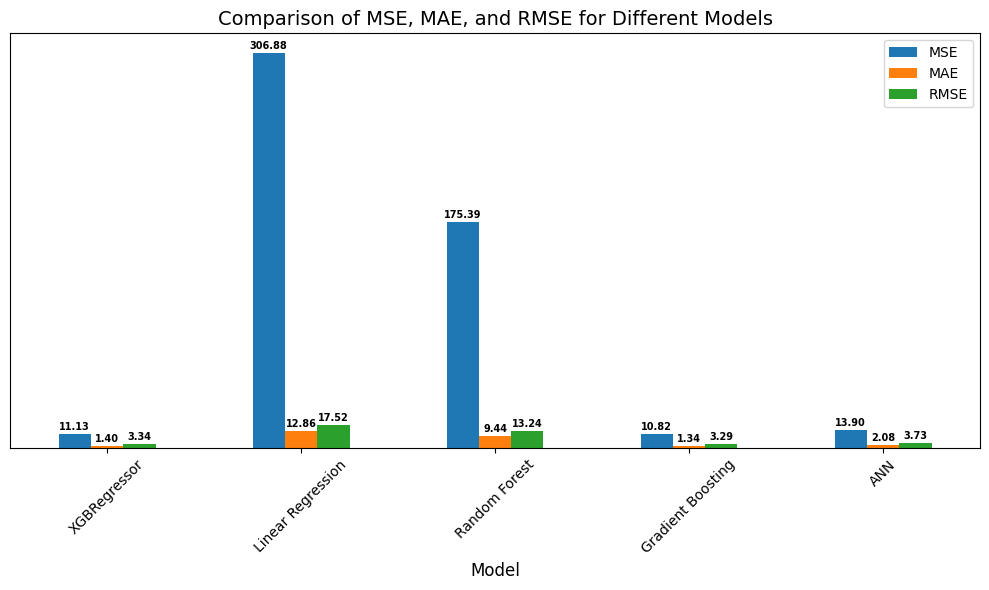

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Don't forget to import pandas

# Values from your code
models = ['XGBRegressor', 'Linear Regression', 'Random Forest', 'Gradient Boosting', 'ANN']
mse_values = [11.13, 306.88, 175.39, 10.82, 13.90]
mae_values = [1.40, 12.86, 9.44, 1.34, 2.08]
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot MSE, MAE, and RMSE for each model
metrics_df.set_index('Model').plot(kind='bar', ax=ax)

# Add labels and title
plt.title('Comparison of MSE, MAE, and RMSE for Different Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=45)

# Remove y-axis
ax.yaxis.set_visible(False)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=7, color='black', fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()

# Show the plot
plt.show()


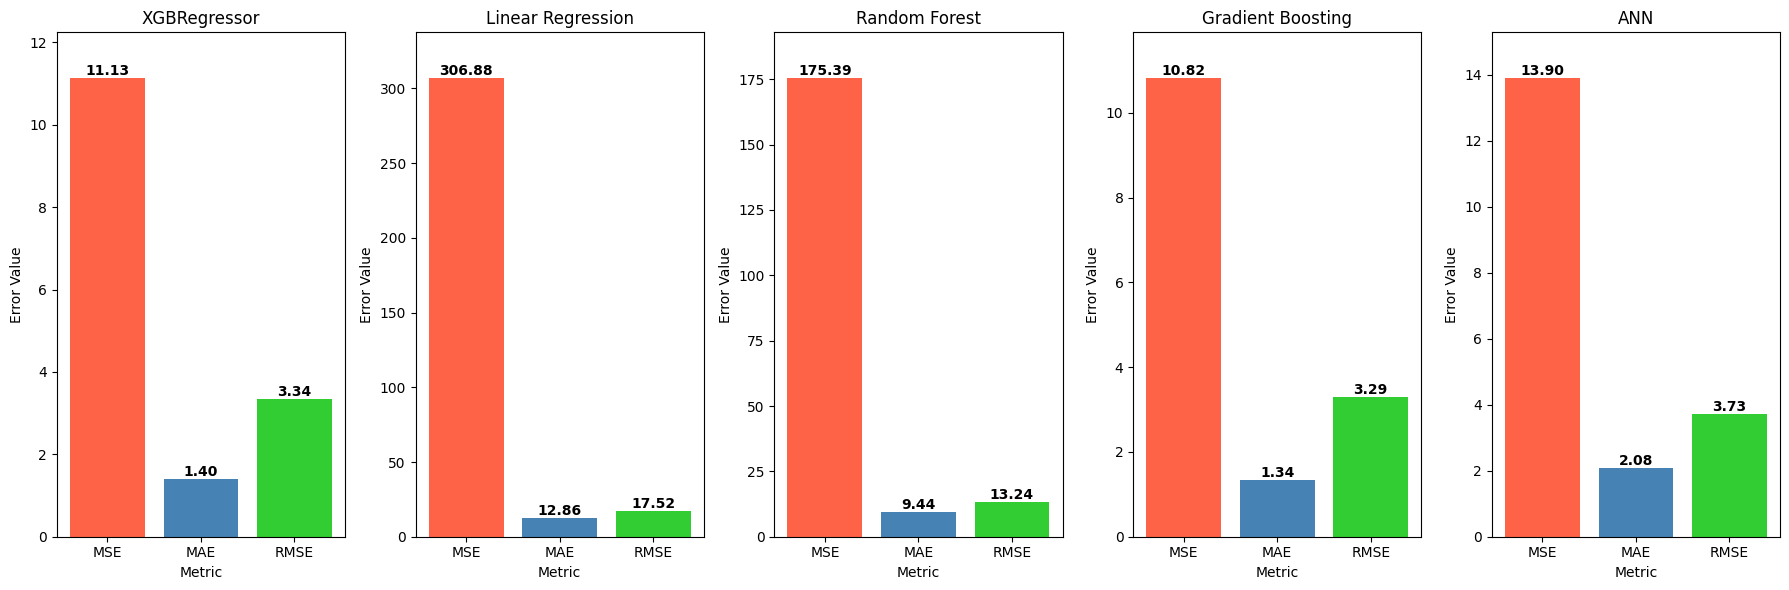

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values from your code
models = ['XGBRegressor', 'Linear Regression', 'Random Forest', 'Gradient Boosting', 'ANN']
mse_values = [11.13, 306.88, 175.39, 10.82, 13.90]
mae_values = [1.40, 12.86, 9.44, 1.34, 2.08]
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(18, 6))

# Define colors for MSE, MAE, and RMSE
colors = ['#FF6347', '#4682B4', '#32CD32']  # Red for MSE, Blue for MAE, Green for RMSE

# Iterate over each model to plot individual charts
for i, model in enumerate(models):
    ax = axes[i]
    bars = ax.bar(['MSE', 'MAE', 'RMSE'], metrics_df.loc[i, ['MSE', 'MAE', 'RMSE']], color=colors)
    ax.set_title(f'{model}')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Error Value')
    ax.set_ylim(0, max(metrics_df.loc[i, ['MSE', 'MAE', 'RMSE']]) * 1.1)  # To give some space for the bars
    
    # Annotate each bar with its value
    for p in bars:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold', xytext=(0, 5), textcoords='offset points')

# Layout adjustments
plt.tight_layout()
plt.show()


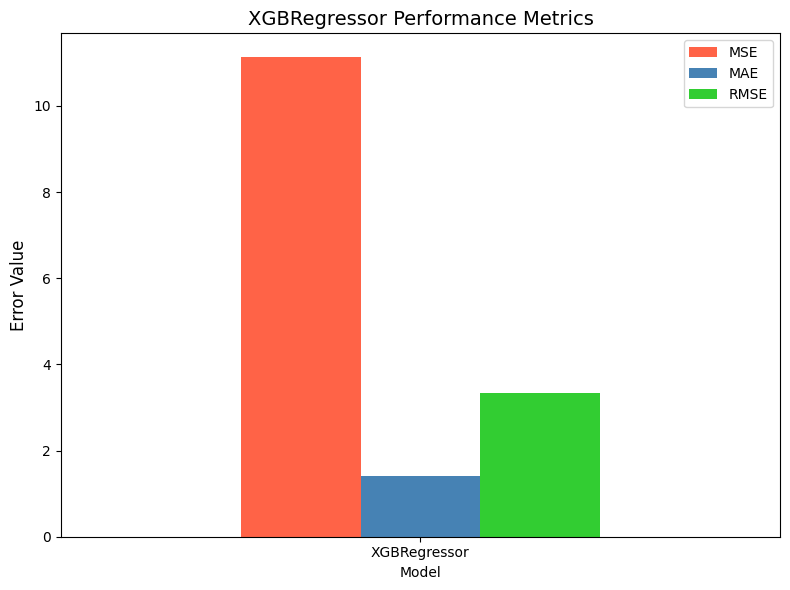

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values for XGBRegressor model (replace with actual values from your code)
model = ['XGBRegressor']
mse_values = [11.13]  # Replace with actual MSE values for XGBRegressor
mae_values = [1.40]   # Replace with actual MAE values for XGBRegressor
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for XGBRegressor
metrics_df = pd.DataFrame({
    'Model': model,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create the plot for XGBRegressor
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the values for XGBRegressor
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#FF6347', '#4682B4', '#32CD32'])  # Red for MSE, Blue for MAE, Green for RMSE

# Add labels and title
plt.title('XGBRegressor Performance Metrics', fontsize=14)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


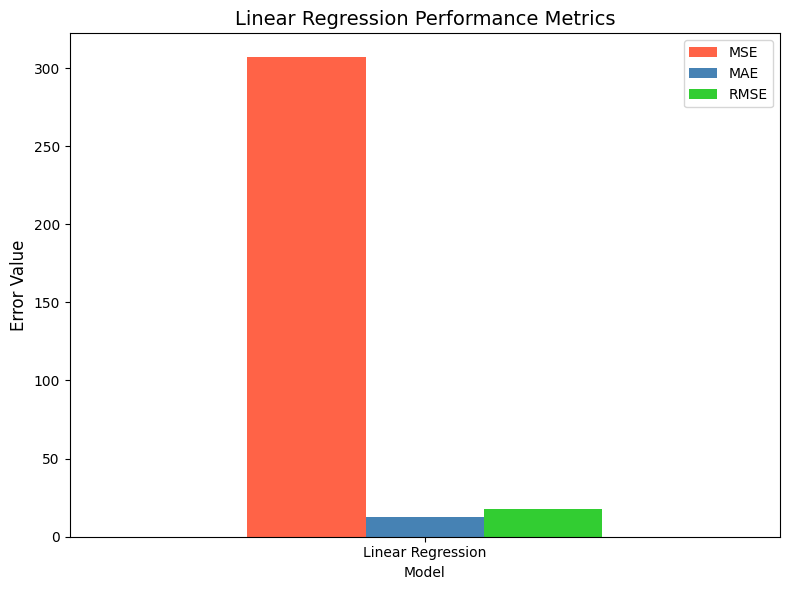

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values for XGBRegressor model (replace with actual values from your code)
model = ['Linear Regression']
mse_values = [306.88]  # Replace with actual MSE values for XGBRegressor
mae_values = [12.86]   # Replace with actual MAE values for XGBRegressor
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for XGBRegressor
metrics_df = pd.DataFrame({
    'Model': model,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create the plot for XGBRegressor
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the values for XGBRegressor
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#FF6347', '#4682B4', '#32CD32'])  # Red for MSE, Blue for MAE, Green for RMSE

# Add labels and title
plt.title('Linear Regression Performance Metrics', fontsize=14)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


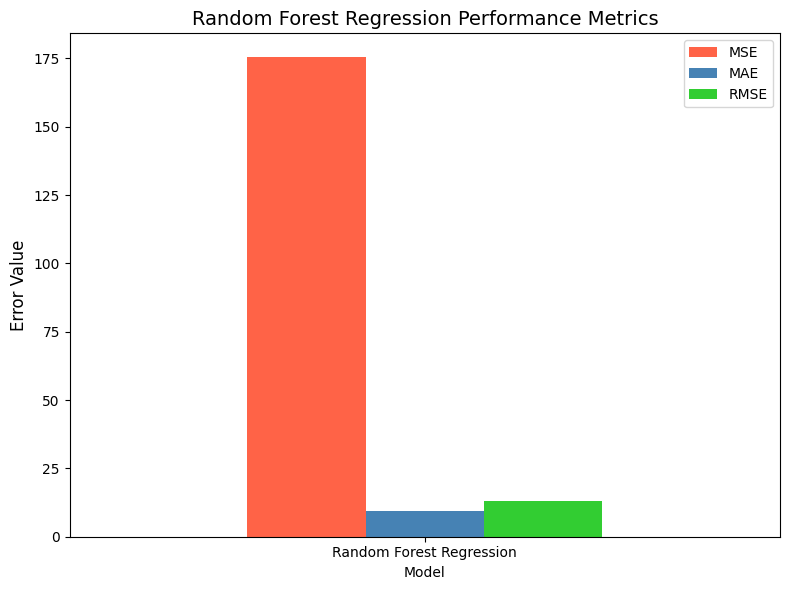

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values for XGBRegressor model (replace with actual values from your code)
model = ['Random Forest Regression']
mse_values = [175.39]  # Replace with actual MSE values for XGBRegressor
mae_values = [9.44]   # Replace with actual MAE values for XGBRegressor
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for XGBRegressor
metrics_df = pd.DataFrame({
    'Model': model,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create the plot for XGBRegressor
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the values for XGBRegressor
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#FF6347', '#4682B4', '#32CD32'])  # Red for MSE, Blue for MAE, Green for RMSE

# Add labels and title
plt.title('Random Forest Regression Performance Metrics', fontsize=14)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


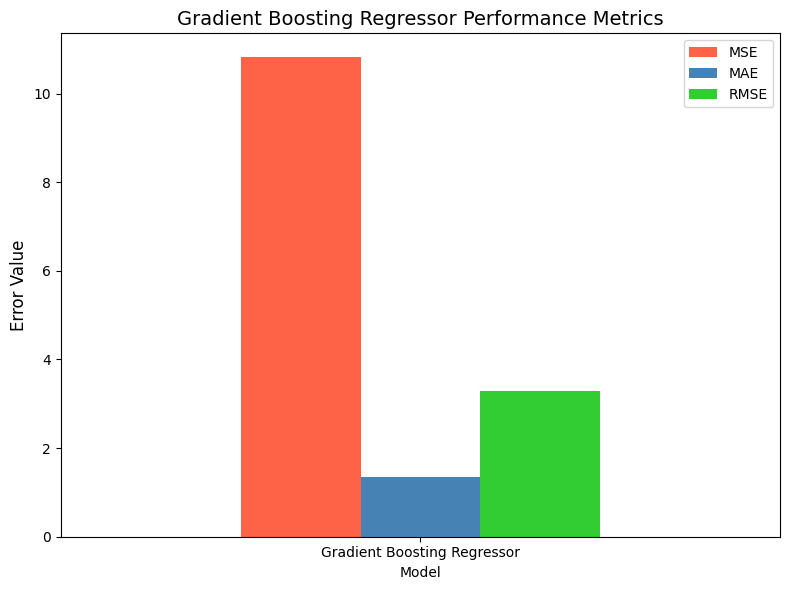

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values for XGBRegressor model (replace with actual values from your code)
model = ['Gradient Boosting Regressor']
mse_values = [10.82]  # Replace with actual MSE values for XGBRegressor
mae_values = [1.34]   # Replace with actual MAE values for XGBRegressor
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for XGBRegressor
metrics_df = pd.DataFrame({
    'Model': model,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create the plot for XGBRegressor
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the values for XGBRegressor
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#FF6347', '#4682B4', '#32CD32'])  # Red for MSE, Blue for MAE, Green for RMSE

# Add labels and title
plt.title('Gradient Boosting Regressor Performance Metrics', fontsize=14)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


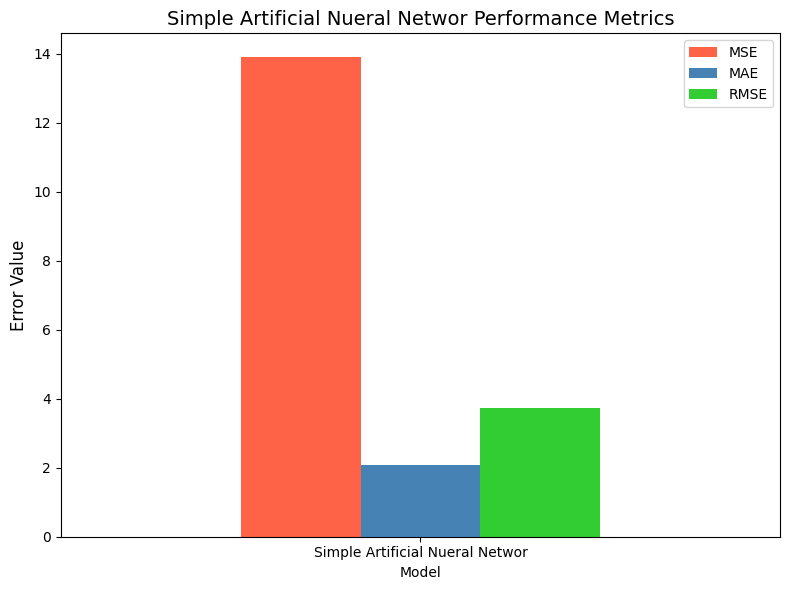

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Values for XGBRegressor model (replace with actual values from your code)
model = ['Simple Artificial Nueral Networ']
mse_values = [13.90]  # Replace with actual MSE values for XGBRegressor
mae_values = [2.08]   # Replace with actual MAE values for XGBRegressor
rmse_values = [np.sqrt(mse) for mse in mse_values]

# Create a DataFrame for XGBRegressor
metrics_df = pd.DataFrame({
    'Model': model,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Create the plot for XGBRegressor
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the values for XGBRegressor
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#FF6347', '#4682B4', '#32CD32'])  # Red for MSE, Blue for MAE, Green for RMSE

# Add labels and title
plt.title('Simple Artificial Nueral Networ Performance Metrics', fontsize=14)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()
